In [57]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [58]:
df = pd.read_csv("sample_data/mnist_train_small.csv")
datavalues = df.values
data = datavalues[:,1:]
labels = datavalues[:,0:1]

data = data.reshape(data.shape[0],1,28,28) # Forming 2D images. Because in the dataset each row consists of 784 pixels of each image.

dataNormalized = data / 255

dataNormalized = torch.tensor(data).float()
labels = torch.tensor(labels).long()

X_train, X_test, y_train, y_test = train_test_split(dataNormalized, labels, test_size=0.1)

training_dataset = TensorDataset(X_train,y_train)
testing_dataset = TensorDataset(X_test,y_test)

batchsize = 32
train_loader = DataLoader(training_dataset, batch_size=batchsize, shuffle=True,drop_last=True)
test_loader = DataLoader(testing_dataset, batch_size=testing_dataset.tensors[0].shape[0])

In [59]:
class CnnModel(nn.Module):
  def __init__(self,print=False):
    super().__init__()
    self.conv1 = nn.Conv2d(1,15,kernel_size=5,stride=1,padding=1)
    #floor((28+2*1-5)/1) +1 = 26( divide by 2 because I set pooling size by 2) = 13
    self.conv2 = nn.Conv2d(15,30,kernel_size=5,stride=1,padding=1)
    #floor((13+2*1-5)/1) +1 = 11 (divide by 2 and floor again) = 5. So before entering fully connected layer, we will have 30 feature maps each is 5x5 which is 750 units in total.
    self.fc1 = nn.Linear(750,100)
    self.fc2 = nn.Linear(100,50)
    self.out = nn.Linear(50,10)
    self.print = print

  def forward(self,x):
    print(f'Input: {x.shape}') if self.print else None
    x = F.relu(F.max_pool2d(self.conv1(x),2))
    print(f'After Layer conv1: {x.shape}') if self.print else None
    x = F.relu(F.max_pool2d(self.conv2(x),2))
    print(f'After Layer conv2: {x.shape}') if self.print else None
    units = x.shape.numel()/x.shape[0] # Calculating 750
    x = x.view(-1,int(units)) # model doesnt know bach size. It is 32 in this case. So reshaping as -1,750. view function automatically replacing -1 with 32 to match to total size. Or we can write manually view(32,750)
    x = F.relu(self.fc1(x))
    print(f'After Layer fc1: {x.shape}') if self.print else None
    x = F.relu(self.fc2(x))
    print(f'After Layer fc2: {x.shape}') if self.print else None
    x = self.out(x)
    print(f'After Layer out: {x.shape}') if self.print else None
    return x


In [60]:
CNN =  CnnModel()
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(CNN.parameters(), lr=learning_rate)
epoch = 30

epochLoss = []

for epochi in range(epoch):
  batchLoss = []
  for X,y in train_loader:
    pred = CNN(X)
    loss = loss_function(pred,y.flatten().long())
    batchLoss.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epochLoss.append(torch.mean(torch.tensor(batchLoss)))



tensor(98.5000)


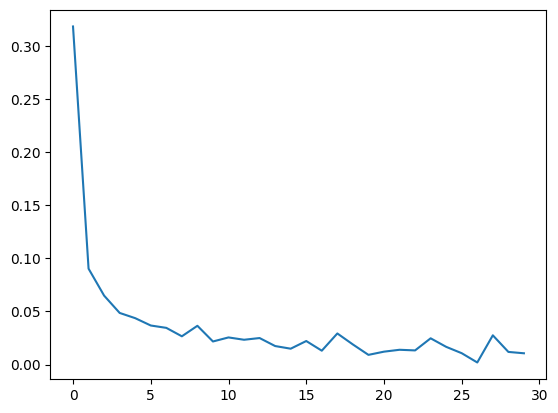

In [61]:
X = list(test_loader)[0][0]
y = list(test_loader)[0][1]
prediction = CNN(X)
matches = (torch.argmax(prediction,axis=1) == y.flatten()).float()
acc = 100*torch.mean(matches)
print(acc.detach())
plt.plot(epochLoss)